In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import datetime
import time
import itertools
import pickle

from VariationalNC.utils import *
from VariationalNC.train import *
from VariationalNC.Variational_layers import VariationalLinear, VariationalConv2d
from VariationalNC.Variational_utils import variational_estimator

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# for plot figures
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible

In [3]:
#load data
with open('Data_Franke_et_al_2021/static25311-10-26.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
print (loaded_dict.keys())

dict_keys(['training_inputs', 'training_responses', 'test_inputs', 'test_responses_repeats'])


## Prepare data for modeling

training inputs shape: (4409, 2, 36, 64)
Max: 255.0


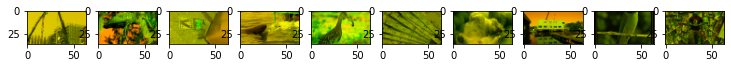

In [4]:
#training data, shape (4409, 2, 36, 64), number of stimuli: 4409, stimuli size: (2, 36, 64)
#the maximum is 255
training_inputs = loaded_dict['training_inputs'] 
#Rescaling，make the data range 0-1.0
#training_inputs=training_inputs/255.0
print ('training inputs shape: {}'.format(training_inputs.shape))
print ('Max: {}'.format(np.max(training_inputs)))
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp = training_inputs[ii]
    temp2 = np.zeros((temp.shape[1],temp.shape[2],3), dtype=np.uint8)
    temp2[:,:,:2] = np.transpose(temp,(1,2,0))[:,:,::-1]
    axes[ii].imshow(temp2)

training responses shape: (4409, 161)


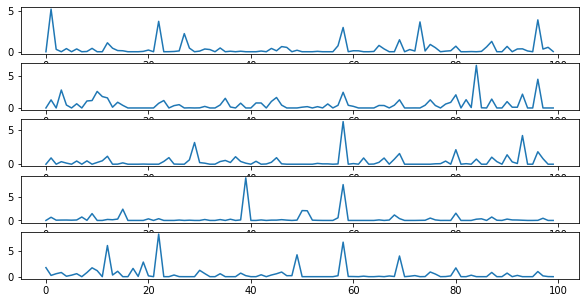

In [5]:
#training responses, shape (4409, 161),number of stimuli: 4409, number of neurons: 161
training_set = loaded_dict['training_responses'] 
print ('training responses shape: {}'.format(training_set.shape))
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(training_set[:100,ii])

test inputs shape: (79, 2, 36, 64)
Max: 255.0


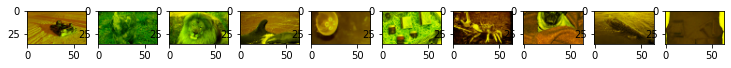

In [6]:
#test data, shape (79, 2, 36, 64), number of stimuli: 79, stimuli size: (2, 36, 64)
test_inputs = loaded_dict['test_inputs'] 
#make the data range 0-1.0
#test_inputs=test_inputs/255.0
print ('test inputs shape: {}'.format(test_inputs.shape))
print ('Max: {}'.format(np.max(test_inputs)))
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp = test_inputs[ii]
    temp2 = np.zeros((temp.shape[1],temp.shape[2],3), dtype=np.uint8)
    temp2[:,:,:2] = np.transpose(temp,(1,2,0))[:,:,::-1]
    axes[ii].imshow(temp2)

test responses shape: (79, 161)


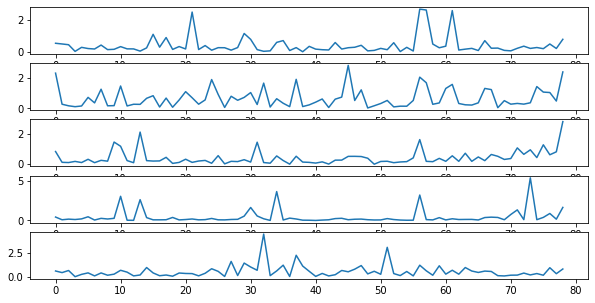

In [7]:
#test data, shape (79, 161), number of stimuli: 79, number of neurons: 161
#test_responses_repeats, shape (79,10,529), 10 repeats
test_set = np.mean(loaded_dict['test_responses_repeats'], axis=1) 
print ('test responses shape: {}'.format(test_set.shape))
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_set[:,ii])

In [9]:
#split original training data into two parts, training loader: 4000, validation loader: 400
train_num, valid_num = 4000, 400
batch_size = 400 # 200
train_mean=np.mean(training_inputs[:train_num], axis=(0,2,3), keepdims=True)/255.0
print (train_mean.shape, train_mean)
#make the dataset suitable for pytorch
train_loader=[]
for ii in range(0,train_num, batch_size):
    temp0=training_inputs[ii:ii+batch_size]/255.0 - train_mean
    #temp0=np.reshape(temp0,(800,31,31))
    #temp0=np.expand_dims(temp0,axis=1)
    temp1=training_set[ii:ii+batch_size] 
    temp=(temp0,temp1)
    train_loader.append(temp)

temp0=training_inputs[train_num : train_num+valid_num]/255.0 - train_mean
#temp0=np.reshape(temp0,(200,31,31))
#temp0=np.expand_dims(temp0,axis=1)
temp1=training_set[train_num : train_num+valid_num] #200*103(neurons)
val_loader=(temp0,temp1)

temp0=np.copy(test_inputs)/255.0 - train_mean
#temp0=np.reshape(temp0,(50,31,31))
#temp0=np.expand_dims(temp0,axis=1)
temp1=np.copy(test_set) #50*103(neurons)
test_loader=(temp0,temp1)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)

(1, 2, 1, 1) [[[[0.48079547]]

  [[0.47780535]]]]
length of train_loader:
10
shape of train_loader[0][0]:
(400, 2, 36, 64)
shape of train_loader[0][1]:
(400, 161)
shape of val_loader[0]:
(400, 2, 36, 64)
shape of val_loader[1]:
(400, 161)
shape of test_loader[0]:
(79, 2, 36, 64)
shape of test_loader[1]:
(79, 161)


In [11]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 50
LR=0.0001
L2=0.0
TEST_SAMPLES = 10

## Models

In [12]:
#
class VanillaCNN(nn.Module):
    def __init__(self,numoffea=48):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)#24,28*56
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,22*50
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        return encoded
#
@variational_estimator
class VariationalCNN(nn.Module):
    def __init__(self,numoffea=48,PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        self.conv1=VariationalConv2d(2,48,kernel_size=(9,9),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#24,23*23
        self.conv2=VariationalConv2d(48,self.numoffea,kernel_size=(7,7),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#48,17*17
        self.fc1  =VariationalLinear(self.numoffea*self.sizeoffea,self.numofneuron,PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)
    def forward(self, x, sampleFlag=False):
        encoded = F.relu(self.conv1(x, sampleFlag))#24,23*23
        encoded = F.relu(self.conv2(encoded, sampleFlag))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded, sampleFlag)) #use exp instead of relu
        return encoded
    
class VanillaCNN_Dropout(nn.Module):
    def __init__(self,numoffea=48,p=0.5):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        #self.dropout1=nn.Dropout(p=p1)
        #self.dropout2=nn.Dropout(p=p2)
        self.dropout=nn.Dropout(p=p)
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = self.conv1(x) #24,23*23
        encoded = F.relu(self.dropout(encoded))
        #encoded = F.relu(encoded)
        encoded = self.conv2(encoded)#48,17*17
        encoded = F.relu(self.dropout(encoded))
        #encoded = F.relu(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = self.fc1(encoded)
        encoded = self.dropout(encoded)
        encoded = torch.exp(encoded) #use exp instead of relu
        return encoded

## Quickly look at VCNN models

2022-07-05 15:02:56.182185
Epoch: 199 val loss: 0.2463, finish training!
2022-07-05 15:09:20.426243
0.26530540840312844

Best Epoch:145
2022-07-05 15:09:20.651618
Epoch: 145 val loss: 0.2653, finish training!
2022-07-05 15:14:00.344456
Overall pearson correlation coefficient:  0.42830924189502534  and p-value:  0.0


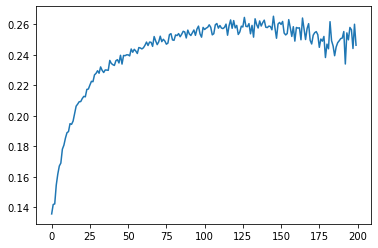

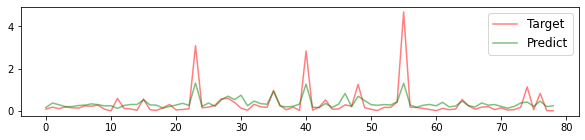

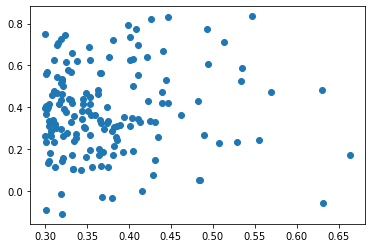

In [18]:
#training VariationalCNN(), record training and validation loss, vbeta=1
tempmodels=['VariationalCNN']
LRs=[0.0003] 
EPOCH=200
train_num=len(train_loader) #number of batches used for training
alpha=None
beta=None
vbeta=1
best_epochs=np.zeros((len(LRs))) # for each LR, the epoch when achieving best val CC
best_valloss=np.zeros((len(LRs))) # for each LR, the best val CC
#
for ii,LR in enumerate(LRs):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]]()
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
#
#best_LR = LRs[np.argmax(best_valloss)]
#best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
best_LR = LRs[0]
best_ep = int(best_epochs[0])
print ('Best Epoch:{}'.format(best_ep))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=best_LR,weight_decay=0.0)
trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
_ = model_test(tempmodel,test_loader,device_cpu,sample_num=100)
testccs,_,_ = model_test_save(tempmodel,test_loader,device_cpu,sample_mean_Flag=False,sample_num=100)
fig,ax=plt.subplots()
ax.scatter(qis,testccs)

In [ ]:
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np_mean[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

## CNN with the best regularizations 

In [ ]:
#training VanillaCNN(), record training and validation loss
tempmodels=['VanillaCNN']
LR=0.0003     
EPOCH=200
train_num=len(train_loader)
alphas_1=[0.0, 100,  1000, 10000, 100000]     #conv1, [0.0, 100,  1000, 10000, 100000]
alphas_2=[0.0, 100,  1000, 10000, 100000]     #conv2, [0.0, 100,  1000, 10000, 100000] 
betas   =[0.0, 0.03, 0.1,  0.3,   1]             #fl, [0.0, 0.03, 0.1,  0.3,   1]  
vbeta=None
best_epochs=np.zeros((len(betas)*len(alphas_1)*len(alphas_2))) # for each train_num, the epoch when achieving best val CC
best_valloss=np.zeros((len(betas)*len(alphas_1)*len(alphas_2))) # for each train_num, the best val CC
train_val_loss=np.zeros((2,(len(betas)*len(alphas_1)*len(alphas_2)),EPOCH))
qq=0
#
for ii in range(len(alphas_1)):
    for jj in range(len(alphas_2)):
        for kk in range(len(betas)):
            modelname=str(qq)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]]()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_num],optimizer,\
                    device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alphas_1[ii],alpha2=alphas_2[jj],\
                    beta=betas[kk],vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,qq],train_val_loss[1,qq]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[qq]  = np.argmax(vallosses)
            best_valloss[qq] = np.max(vallosses)
            print ('{}\n'.format(best_valloss[kk]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            qq=qq+1
#
temp2=np.reshape(np.array(best_valloss),(len(alphas_1),len(alphas_2),len(betas)))
print(temp2)

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_regularizations_train_val_loss.npy', train_val_loss)

In [ ]:
tempmodels=['VanillaCNN']
best_kk=int(np.argmax(best_valloss))
best_a,yyy=divmod(best_kk,len(alphas_2)*len(betas))
best_b, best_c=divmod(yyy,len(betas))
best_alpha1=alphas_1[best_a]
best_alpha2=alphas_2[best_b]
best_beta=betas[best_c]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best alpha1: {} Best alpha2: {}  Best beta: {} and Epoch:{}'.format(best_alpha1,best_alpha2,best_beta,best_ep))
print ('Best val loss: {}'.format(np.max(best_valloss)))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_num],optimizer,\
                device,best_ep,Ploss_L2L1_SE_regularizaion_2conv,alpha1=best_alpha1,alpha2=best_alpha2,\
                beta=best_beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
_ = model_test(tempmodel,test_loader,device_cpu,sample_num=100)
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# # RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [ ]:
train_val_loss=np.load('out_2YQ_Franke2021/CNN_regularizations_train_val_loss.npy')
print(np.max(train_val_loss[1]))
#print(np.max(train_val_loss[1,227]))
plt.plot(train_val_loss[1,np.argmax(np.max(train_val_loss[1],axis=1))])

## CNN with MC dropout

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss.npy', train_val_loss)

In [ ]:
#train_val_loss=np.load('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss.npy')
#print(np.max(train_val_loss[1]))
#print(np.max(train_val_loss[1,141]))
#print(np.argmax(train_val_loss[1,141]))

In [ ]:
tempmodels=['VanillaCNN_Dropout']   #MC dropout
LRs=0.0003     
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=None
drop_out_num=100
dropout_p=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # use 0.01 instead of 0 for very small dropout rates
train_val_loss=np.zeros((2,len(dropout_p),EPOCH))
best_epochs=np.zeros(len(dropout_p)) 
best_valloss=np.zeros(len(dropout_p)) 
for ii in range(len(dropout_p)):
    model_parameters = {'p':dropout_p[ii]}
    modelname=str(ii)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]](**model_parameters)
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LRs,weight_decay=0.0)
    trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    drop_out_num,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
    
temp2=np.reshape(np.array(best_valloss),(10,1))
print(temp2) 

2022-05-16 18:05:31.222062
Epoch: 199 val loss: 0.1069, finish training!
2022-05-16 18:24:21.395985
0.26443996210880305

2022-05-16 18:24:21.688510
Epoch: 199 val loss: 0.1349, finish training!
2022-05-16 18:43:03.707562
0.2658858276545062

2022-05-16 18:43:04.081855


In [ ]:
tempmodels=['VanillaCNN_Dropout']   #MC dropout
best_kk=int(np.argmax(best_valloss))
best_p=dropout_p[best_kk]
best_ep = int(best_epochs[best_kk]) #epoch
print ('Best dropout rate: {} and Epoch:{}'.format(best_p, best_ep))
best_ep = best_ep + 1
modelname=str(1)
model_parameters = {'p':best_p}
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]](**model_parameters)
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE,drop_out_num, alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
_ = model_val_drop_out(tempmodel,test_loader,device_cpu,drop_out_num=100, sample_num=100, plot_flag=True)
# RF_fl=vis_model_fl_dropout(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np_mean[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss_defaults.npy', train_val_loss)

In [ ]:
#somehow, for this data, only one seed could not select the best dropout rate, so here we select the dropout 
#based on 10 seeds
tempmodels=['VanillaCNN_Dropout']   #MC dropout
LRs=0.0003     #best LR 
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=None
seeds=np.arange(1,11)
drop_out_num=100
dropout_p=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # use 0.01 instead of 0 for very small dropout rates
#train_val_loss=np.zeros((2,len(dropout_p),EPOCH))
#best_epochs=np.zeros(len(dropout_p)) 
best_valloss=np.zeros((len(dropout_p), len(seeds))) 
for ii in range(len(dropout_p)):
    for jj in range(len(seeds)):
        model_parameters = {'p':dropout_p[ii]}
        modelname=str(ii)
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LRs,weight_decay=0.0)
        trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE,drop_out_num,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,\
                    valdata=val_loader,valdevice=device,verbose=False)
        #train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
        del tempmodel
        torch.cuda.empty_cache()
        #best_epochs[ii]  = np.argmax(vallosses)
        best_valloss[ii,jj] = np.max(vallosses)

In [ ]:
print ('Best dropout rate: {}'.format(dropout_p[np.argmax(np.mean(best_valloss, axis=1))]))
print (np.mean(best_valloss, axis=1))
print (best_valloss)

## Tune the best beta

In [ ]:
tempmodels=['VanillaCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)  
alpha=0
beta=0
vbetas=[None, 0.1, 0.3, 1.0, 3.0, 10]
train_val_loss=np.zeros((2,len(tempmodels),EPOCH)) # 2: train and val loss
best_epochs=np.zeros(len(tempmodels)) 
best_valloss=np.zeros(len(tempmodels)) 
#
for ii in range(len(tempmodels)):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[ii]]() #tempmodels[ii]
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    #temp=model_train(tempmodel,train_loader,optimizer,device,50,Ploss_L2L1_SE,alpha=None,beta=None)
    trainlosses,vallosses=model_train(tempmodel,train_loader[:train_nums],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    alpha=alpha,beta=beta,vbeta=vbetas[ii],earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    #modeltrainloss.append(temp)
    #torch.save(tempmodel.state_dict(), './out_20200810/VariationalLN_SimulationData_'+modelname+'.pth')
    #temp=model_val(tempmodel,val_loader,20,device_cpu,loss_mse)
    #modelvalloss.append(temp)
    #release gpu memory
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
#
print (train_val_loss.shape)

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_train_val_loss_beta.npy', train_val_loss)

In [ ]:
tempmodels = ['VariationalCNN']   
best_kk = int(np.argmax(best_valloss))
best_vbeta = vbetas[best_kk]
best_ep = int(best_epochs[best_kk]) #epoch
print ('Best vbeta: {} and Epoch:{}'.format(best_vbeta, best_ep))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=best_vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
#
_ = model_test(tempmodel,test_loader,device_cpu,sample_num=100)
#
testccs,_,_ = model_test_save(tempmodel,test_loader,device_cpu,sample_mean_Flag=False,sample_num=100)
fig,ax=plt.subplots()
ax.scatter(qis,testccs)
#
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np_mean[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [ ]:
train_val_loss=np.load('out_2YQ_Franke2021/CNN_train_val_loss_beta.npy')
print (train_val_loss.shape)
print(np.max(train_val_loss[1,0]))
print(np.max(train_val_loss[1,1]))
print(np.max(train_val_loss[1,2]))
print(np.max(train_val_loss[1,3]))
print(np.max(train_val_loss[1,4]))
print(np.max(train_val_loss[1,5]))
#print(np.max(train_val_loss[1,6]))

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,0,:],color='k',linestyle='-',label='CNN')
ax.plot(train_val_loss[1,1,:],color='r',linestyle='-',label='VCNN, $\\beta$=0.1')
ax.plot(train_val_loss[1,2,:],color='g',linestyle='-',label='VCNN, $\\beta$=0.3')
ax.plot(train_val_loss[1,3,:],color='b',linestyle='-',label='VCNN, $\\beta$=1.0')
ax.plot(train_val_loss[1,4,:],color='c',linestyle='-',label='VCNN, $\\beta$=3.0')
ax.plot(train_val_loss[1,5,:],color='y',linestyle='-',label='VCNN, $\\beta$=10')
#ax.plot(train_val_loss[1,6,:],color='m',linestyle='-',label='VCNN, $\\beta$=3.0')
#for ii in range(len(lossweights)):
#    ax.plot(train_val_loss[1,3,:100],color=colors[ii],label='{}'.format(lossweights[ii]))
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0, 0.4])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.2,0.4])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/VariationalCNN_SimulationData_seed_1_valloss_beta.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## Test different prior distribution
mixture of Gaussian, Gaussian with small std, Gaussian with large std

In [ ]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=0.1
pis = [0.2, 0.5, 0.8]    
sigma1s = [1, 10, 100]
sigma2s=[0.04978706, 0.00247875, 0.00012341]

train_val_loss=np.zeros((2,(len(pis)*len(sigma1s)*len(sigma2s)),EPOCH))
best_epochs=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the epoch when achieving best val CC
best_valloss=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the best val CC
kk=0
for pi in pis:
    for s1 in sigma1s:
        for s2 in sigma2s:
            model_parameters = {'PI':pi, 'SIGMA_1':s1, 'SIGMA_2':s2}
            modelname=str(kk)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]](**model_parameters)
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,kk],train_val_loss[1,kk]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[kk]= np.argmax(vallosses)
            best_valloss [kk]= np.max(vallosses)
            print ('{}\n'.format(best_valloss[kk]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            kk=kk+1
                     
temp2=np.reshape(np.array(best_valloss),(3,3,3))
print(temp2)            
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))


In [ ]:
#np.save('temp/dataFranke_VCNN_best_valloss_mixture_Gaussian_defaults.npy',best_valloss)

In [15]:
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))

Best pi: 0.5 Best sigma1: 100 Best sigma2: 0.00012341 and Best epoch: 87 


In [16]:
print(temp2)

[[[0.2653763  0.27387806 0.27639153]
  [0.26542385 0.27521598 0.27830422]
  [0.26541002 0.27752178 0.27844993]]

 [[0.26537889 0.2741233  0.27548226]
  [0.2653687  0.27403011 0.27642135]
  [0.26543378 0.27646317 0.27961465]]

 [[0.26529824 0.27423547 0.27519273]
  [0.26537328 0.27366755 0.27804691]
  [0.26541106 0.2746298  0.27925764]]]


In [ ]:
#np.save('out_2YQ_Franke2021/VCNN_train_val_loss_mixture_Gaussian_defaults.npy', train_val_loss)

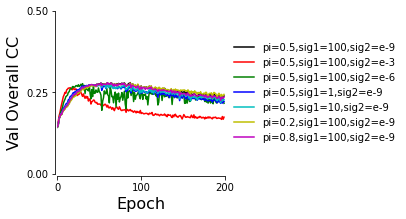

In [18]:
train_val_loss=np.load('out_2YQ_Franke2021/VCNN_train_val_loss_mixture_Gaussian_defaults.npy')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,17,:],color='k',linestyle='-',label='pi=0.5,sig1=100,sig2=e-9')
ax.plot(train_val_loss[1,15,:],color='r',linestyle='-',label='pi=0.5,sig1=100,sig2=e-3')
ax.plot(train_val_loss[1,16,:],color='g',linestyle='-',label='pi=0.5,sig1=100,sig2=e-6')
ax.plot(train_val_loss[1,11,:],color='b',linestyle='-',label='pi=0.5,sig1=1,sig2=e-9')
ax.plot(train_val_loss[1,14,:],color='c',linestyle='-',label='pi=0.5,sig1=10,sig2=e-9')
ax.plot(train_val_loss[1,8,:],color='y',linestyle='-',label='pi=0.2,sig1=100,sig2=e-9')
ax.plot(train_val_loss[1,26,:],color='m',linestyle='-',label='pi=0.8,sig1=100,sig2=e-9')

ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0, 0.5])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0, 0.25, 0.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/mixture_Gaussian_train_val_loss_VCNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## CNN with regularizations vs. best varitionalCNN vs. CNN with dropout

#### Validation loss against epoch number

In [ ]:
train_val_loss_CNN_L1L2=np.load('out_2YQ_Franke2021/CNN_regularizations_train_val_loss.npy')
train_val_loss_VCNN=np.load('out_2YQ_Franke2021/VCNN_train_val_loss_sample_num.npy')
train_val_loss_CNN_dropout=np.load('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss_defaults.npy')
print(np.max(train_val_loss_CNN_L1L2[1]))
print(np.max(train_val_loss_VCNN[1]))
print(np.max(train_val_loss_CNN_dropout[1]))
print(np.max(train_val_loss_CNN_L1L2[1,227]))
print(np.max(train_val_loss_VCNN[1,1]))
print(np.max(train_val_loss_CNN_dropout[1,7]))

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss_CNN_L1L2[1,227,:],color='r',linestyle='-',label='CNN with regularizations')
ax.plot(train_val_loss_VCNN[1,1,:],color='g',linestyle='-',label='VCNN')
ax.plot(train_val_loss_CNN_dropout[1,7,:],color='b',linestyle='-',label='CNN with dropout')
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0,0.5])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.25,0.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Validation_loss_against_epoch_number_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')


#### Predictive performance against amount of training data
10 seeds, test data

In [ ]:
tempmodels=['VanillaCNN']  #without regularization
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha_1=0
alpha_2=0
beta=0
vbeta=None
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums), len(seeds)))

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    tempepoch,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            'noregu__trainnum_' + str(ii)+ '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN_noregu.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN']              #with regularization
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha_1=1000
alpha_2=1000
beta=1
vbeta=None
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums), len(seeds)))

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    tempepoch,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            '_trainnum_' + str(ii)+ '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN.npy', test_losses)

In [ ]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=None
beta=None
vbetas=0.3
sampling_number=1
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_sample_num(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                EPOCH,Ploss_L2L1_SE,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,\
                valdevice=device,verbose=False,sampling_num=sampling_number)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_sample_num(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            '_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_Dropout']
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=0
beta=0
vbetas=None
drop_out_num=100
model_parameters = {'p':0.1} # 0.3
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_drop_out(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE,drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,\
                    valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_drop_out(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                tempepoch,Ploss_L2L1_SE,drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,\
                valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
             '_trainnum_' + str(ii) + '_Franke2021Data_trainN_'+ '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val_drop_out(tempmodel,test_loader,device,drop_out_num,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_dropout_Franke2021Data_test_losses.npy', test_losses)

In [13]:
test_losses_CNN_noregu=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN_noregu.npy')
print (test_losses_CNN_noregu.shape)
test_losses_CNN_noregu_mean=np.mean(test_losses_CNN_noregu,axis=1)
test_losses_CNN_noregu_std =np.std (test_losses_CNN_noregu,axis=1,ddof=1)
print(np.max(test_losses_CNN_noregu_mean))
print(np.max(test_losses_CNN_noregu_std))

test_losses_CNN=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN.npy')
print (test_losses_CNN.shape)
test_losses_CNN_mean=np.mean(test_losses_CNN,axis=1)
test_losses_CNN_std =np.std (test_losses_CNN,axis=1,ddof=1)
print(np.max(test_losses_CNN_mean))
print(np.max(test_losses_CNN_std))

test_losses_VCNN=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses.npy')
print (test_losses_VCNN.shape)
test_losses_VCNN_mean=np.mean(test_losses_VCNN,axis=1)
test_losses_VCNN_std =np.std (test_losses_VCNN,axis=1,ddof=1)
print(np.max(test_losses_VCNN_mean))
print(np.max(test_losses_VCNN_std))

test_losses_CNN_dropout=np.load('out_2YQ_Franke2021/CNN_dropout_Franke2021Data_test_losses.npy')
print (test_losses_CNN_dropout.shape)
test_losses_CNN_dropout_mean=np.mean(test_losses_CNN_dropout,axis=1)
test_losses_CNN_dropout_std =np.std (test_losses_CNN_dropout,axis=1,ddof=1)
print(np.max(test_losses_CNN_dropout_mean))
print(np.max(test_losses_CNN_dropout_std))

(5, 10)
0.41300402277237136
0.013218321761880772
(5, 10)
0.4256045720074952
0.017494958389545866
(5, 10)
0.43909204831244225
0.01848817787787264
(5, 10)
0.4141027468173652
0.01140798526511972


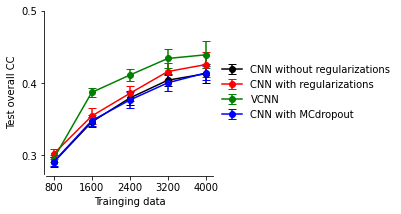

In [14]:
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
templabels= [str(ii*batch_size) for ii in train_nums]#['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_noregu_mean,yerr=test_losses_CNN_noregu_std,\
            marker='o', color='k',linestyle='-',label='CNN without regularizations',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_mean,yerr=test_losses_CNN_std,\
            marker='o', color='r',linestyle='-',label='CNN with regularizations',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_VCNN_mean,yerr=test_losses_VCNN_std,\
            marker='o', color='g',linestyle='-',label='VCNN',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_dropout_mean,yerr=test_losses_CNN_dropout_std,\
            marker='o', color='b',linestyle='-',label='CNN with MCdropout',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_yticks([0.3,0.4,0.5])
#ax.set_ylim(ymin=0.5)
ax.set_xticklabels(templabels)
ax.set_xlabel('Trainging data')
ax.set_ylabel('Test overall CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/Predictive_performance_against_trainingSize_allSeeds_testCC_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [15]:
diff_value=test_losses_VCNN-test_losses_CNN
print(diff_value.shape)
diff_value_mean=np.mean(diff_value,axis=1)
diff_value_std =np.std(diff_value,axis=1,ddof=1)

(5, 10)


In [18]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
print (perm_test(test_losses_VCNN[1],test_losses_CNN[1],nmc=10000,randomseed=66))
print (perm_test(test_losses_VCNN[4],test_losses_CNN[4],nmc=10000,randomseed=66))

0.0
0.1096


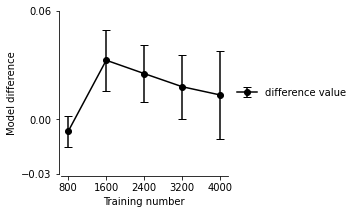

In [23]:
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
templabels= [str(ii*batch_size) for ii in train_nums]#['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),diff_value_mean,yerr=diff_value_std,\
            marker='o', color='k',linestyle='-',label='difference value',alpha=1, capsize=4)
ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_yticks([-0.03,0,0.06])
#ax.set_ylim(ymin=0.5)
ax.set_xticklabels(templabels)
ax.set_xlabel('Training number')
ax.set_ylabel('Model difference')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/Predictive_performance_against_trainingSize_allSeeds_difference.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [19]:
# with regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_1_Franke2021Data_trainN__seed_8.pth'))
encoded_np_rcnn_0,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np_rcnn_0.shape)
print (y.shape)
#
testcc_rcnn_0=np.zeros(test_loader[1].shape[1])
testpvalue_rcnn_0=np.zeros(test_loader[1].shape[1])
for ii in range(test_loader[1].shape[1]):
    testcc_rcnn_0[ii],testpvalue_rcnn_0[ii]=pearsonr(encoded_np_rcnn_0[:,ii], y[:,ii])

(79, 161)
(79, 161)


In [20]:
# with regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_8.pth'))
encoded_np_rcnn_1,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np_rcnn_1.shape)
print (y.shape)
#
testcc_rcnn_1=np.zeros(test_loader[1].shape[1])
testpvalue_rcnn_1=np.zeros(test_loader[1].shape[1])
for ii in range(test_loader[1].shape[1]):
    testcc_rcnn_1[ii],testpvalue_rcnn_1[ii]=pearsonr(encoded_np_rcnn_1[:,ii], y[:,ii])

(79, 161)
(79, 161)


In [21]:
#tempmodel= VariationalCNN()
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(9)    # reproducible
torch.cuda.manual_seed(9)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_1_Franke2021Data_trainN__seed_8.pth'))
encoded_np_vcnn_0,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np_vcnn_0.shape)
print (y.shape)
encoded_np_vcnn_0_std=np.std(encoded_np_vcnn_0[:100], axis=0,ddof=1)     #only use sampling numbers 100, not 101
encoded_np_vcnn_0   =np.mean(encoded_np_vcnn_0[:100],axis=0)
print (encoded_np_vcnn_0.shape)
#
testcc_vcnn_0=np.zeros(test_loader[1].shape[1])
testpvalue_vcnn_0=np.zeros(test_loader[1].shape[1])

for ii in range(test_loader[1].shape[1]):
    testcc_vcnn_0[ii],testpvalue_vcnn_0[ii]=pearsonr(encoded_np_vcnn_0[:,ii], y[:,ii])

(101, 79, 161)
(79, 161)
(79, 161)


In [22]:
#tempmodel= VariationalCNN()
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(9)    # reproducible
torch.cuda.manual_seed(9)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_8.pth'))
encoded_np_vcnn_1,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np_vcnn_1.shape)
print (y.shape)
encoded_np_vcnn_1_std=np.std(encoded_np_vcnn_1[:100], axis=0,ddof=1)     #only use sampling numbers 100, not 101
encoded_np_vcnn_1    =np.mean(encoded_np_vcnn_1[:100],axis=0)
print (encoded_np_vcnn_1.shape)
#
testcc_vcnn_1=np.zeros(test_loader[1].shape[1])
testpvalue_vcnn_1=np.zeros(test_loader[1].shape[1])

for ii in range(test_loader[1].shape[1]):
    testcc_vcnn_1[ii],testpvalue_vcnn_1[ii]=pearsonr(encoded_np_vcnn_1[:,ii], y[:,ii])

(101, 79, 161)
(79, 161)
(79, 161)


In [23]:
temp=np.zeros(test_loader[1].shape[1])
for ii in range(test_loader[1].shape[1]):
    temp[ii]=testcc_vcnn_0[ii]-testcc_rcnn_0[ii]
len([i for i  in temp if i >0])

122

In [24]:
temp=np.zeros(test_loader[1].shape[1])
for ii in range(test_loader[1].shape[1]):
    temp[ii]=testcc_vcnn_1[ii]-testcc_rcnn_1[ii]
len([i for i  in temp if i >0])

103

No handles with labels found to put in legend.


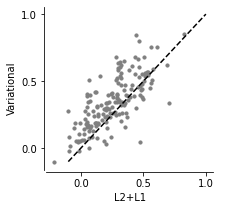

In [25]:
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.scatter(testcc_rcnn_0.flatten(),testcc_vcnn_0.flatten(),s=10,c='gray')
ax.plot([-0.1,1],[-0.1,1],ls='--',c="k")
ax.set_xlabel('L2+L1')
ax.set_ylabel('Variational')
ax.set_xticks([0,0.5,1.0])
ax.set_yticks([0,0.5,1.0])
ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/scatter_responce_cc_seed9_trainnum1.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

No handles with labels found to put in legend.


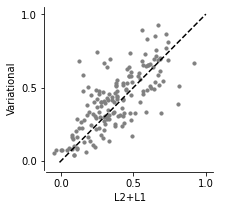

In [26]:
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.scatter(testcc_rcnn_1.flatten(),testcc_vcnn_1.flatten(),s=10,c='gray')
ax.plot([-0.01,1],[-0.01,1],ls='--',c="k")
ax.set_xlabel('L2+L1')
ax.set_ylabel('Variational')
ax.set_xticks([0,0.5,1.0])
ax.set_yticks([0.0,0.5,1.0])
ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/scatter_responce_cc_seed9_trainnum4.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [27]:
print (perm_test(testcc_rcnn_0,testcc_vcnn_0,nmc=10000,randomseed=66))
print (perm_test(testcc_rcnn_1,testcc_vcnn_1,nmc=10000,randomseed=66))

0.0
0.0927


#### Predictive response with std

In [39]:
Neurons=[95,123]

(79, 161)
(79, 161)


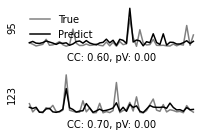

In [46]:
#no regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNNnoregu__trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='k',linestyle='-',label='Predict')
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_CNN_noregu.svg')

(79, 161)
(79, 161)


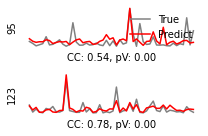

In [18]:
# with regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='r',linestyle='-',label='Predict')
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_CNN.svg')

(101, 79, 161)
(79, 161)
(79, 161)


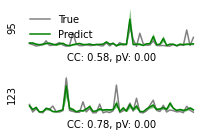

In [40]:
#tempmodel= VariationalCNN()
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
encoded_np_std=np.std(encoded_np[:100], axis=0,ddof=1)     #only use sampling numbers 100, not 101
encoded_np    =np.mean(encoded_np[:100],axis=0)
print (encoded_np.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='g',linestyle='-',label='Predict')
    axes[ii].fill_between(np.arange(50),y1=encoded_np[:50,Neurons[ii]]+encoded_np_std[:50,Neurons[ii]],\
                          y2=encoded_np[:50,Neurons[ii]]-encoded_np_std[:50,Neurons[ii]],color='g',linewidth=0,alpha=0.5)
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_VCNN.svg')

(100, 79, 161)
(79, 161)
(79, 161)


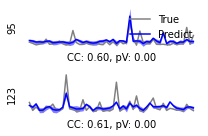

In [42]:
#tempmodel=VanillaCNN_Dropout()
tempmodels=['VanillaCNN_Dropout']
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
model_parameters = {'p':0.1 }
tempmodel = globals()[tempmodels[0]](**model_parameters)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_Dropout_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict_dropout(tempmodel,test_loader,device,drop_out_num=100,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
encoded_np_std=np.std(encoded_np, axis=0,ddof=1)
encoded_np    =np.mean(encoded_np,axis=0)
print (encoded_np.shape)


nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='b',linestyle='-',label='Predict')
    axes[ii].fill_between(x=np.arange(50),y1=encoded_np[:50,Neurons[ii]]+encoded_np_std[:50,Neurons[ii]],\
                          y2=encoded_np[:50,Neurons[ii]]-encoded_np_std[:50,Neurons[ii]],color='b',linewidth=0,alpha=0.5)
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_CNN_MCdropout.svg')